In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import datetime

file = 'Diff_Relapse_01'

In [2]:
rawLinks = pd.read_csv('data/9606.protein.links.v10.5.txt', delim_whitespace=True)
rawAlias = pd.read_csv('data/9606.protein.aliases.v10.5.txt', delimiter='\t')
print('Here')
print(str(datetime.datetime.now()))

Here
2019-01-18 18:55:20.332398


In [3]:
#build a map of proteinId in rawLinks to gene product names
proteinIdToAlias = {}
aliasToProteinId = {}
duplicatedAliases = []
for val in list(zip(rawAlias.string_protein_id, rawAlias.alias)):
    if val[1] in aliasToProteinId:
        duplicatedAliases.append(str(val[1]))
        aliasToProteinId[val[1]].append(val[0])
    else:
        aliasToProteinId[val[1]] = [val[0]]
    
    if not val[0] in proteinIdToAlias: #the alias file has lots of duplicates!
        proteinIdToAlias[val[0]]=[val[1]]
    else:
        proteinIdToAlias[val[0]].append(val[1])
        
print('Here')
print('There are ', len(duplicatedAliases), ' aliases which point to multiple protein ids')
print(str(datetime.datetime.now()))

Here
There are  50394  aliases which point to multiple protein ids
2019-01-18 18:55:24.326894


In [4]:
#build the list of links mapped to gene product name
links = list(zip(rawLinks.protein1, rawLinks.protein2, rawLinks.combined_score))
links = [list(elem) for elem in links]
print('Here')
print(str(datetime.datetime.now()))

Here
2019-01-18 18:55:34.440047


In [5]:
#filter links where both in and out are in the dataset
acceptableGeneList = pd.read_csv(file + '.txt', header=None)
acceptableGeneSet = set(acceptableGeneList[0])

print(str(datetime.datetime.now()))
print('There are ', len(acceptableGeneList), ' acceptable gene products')

print('Determining gene products which have multiple protein ids')
problematic = list(acceptableGeneSet.intersection(duplicatedAliases))
print('There are ', len(problematic), ' aliases which have multiple protein ids');

filteredLinks = []
for link in links:
    aliasesOfStart = proteinIdToAlias[link[0]]
    aliasesOfEnd = proteinIdToAlias[link[1]]
    
    startIsAcceptable = not acceptableGeneSet.isdisjoint(aliasesOfStart)
    endIsAcceptable = not acceptableGeneSet.isdisjoint(aliasesOfEnd)
    
    if startIsAcceptable and endIsAcceptable:
        filteredLinks.append(link)
        
print('There are ', len(filteredLinks), ' filtered links')
print(str(datetime.datetime.now()))

2019-01-18 18:55:34.451984
There are  1433  acceptable gene products
Determining gene products which have multiple protein ids
There are  91  aliases which have multiple protein ids
There are  115468  filtered links
2019-01-18 18:57:00.602287


In [6]:
#transform filtered links to not use protein ids but rather aliases (or a combination)
print('Transform the filtered links...')
print(str(datetime.datetime.now()))
for geneProduct in acceptableGeneSet:
    if not geneProduct in aliasToProteinId:
        continue
        
    proteinIds = aliasToProteinId[geneProduct]
    for proteinId in proteinIds:
        for link in filteredLinks:
            if link[0] == proteinId:
                link[0] = geneProduct
            
            if link[1] == proteinId:
                link[1] = geneProduct

print('Done...')
print(str(datetime.datetime.now()))

Transform the filtered links...
2019-01-18 18:57:00.608970
Done...
2019-01-18 18:57:40.432895


In [7]:
print(str(datetime.datetime.now()))
G = nx.DiGraph()
G.add_weighted_edges_from(filteredLinks)
nx.write_gml(G, 'out/gephi/grid_'+ file + '.gml')
print('Now open out/gephi/grid_'+ file + '.gml')
print(str(datetime.datetime.now()))

2019-01-18 18:57:40.437991
Now open out/gephi/grid_Diff_Relapse_01.gml
2019-01-18 18:57:41.075862


(array([58036., 18724.,  9704.,  6766.,  4502.,  3394.,  2326.,  2474.,
         4824.,  4718.]),
 array([150. , 234.9, 319.8, 404.7, 489.6, 574.5, 659.4, 744.3, 829.2,
        914.1, 999. ]),
 <a list of 10 Patch objects>)

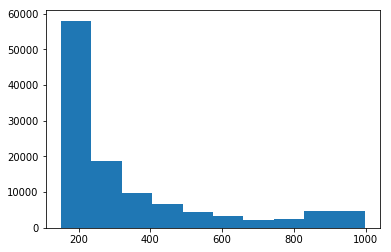

In [8]:
weights = []
for link in filteredLinks:
    weights.append(link[2])
    
plt.hist(weights)